<h1> <big> Indoor Locationing by wifi fingerprinting </big> </h1> 
<h3> Vera Giulia Sala - Ubiqum Code Academy </h3>

<ol> 
  <li><a href="#p1"> Goal of the analysis</a></li> 
  <li><a href="#p2">Dataset</a></li> 
  <li><a href="#p4">Preprocessing and explorative analysis of data</a></li> 
      <ol>   <li> <a href="#p4_1">First exploration of data and feature redefinition</a> </li> 
             <li> <a href="#p4_2">Data visualization</a> </li>
             <li> <a href="#p4_3">Removing outliers</a> </li>
             <li> <a href="#p4_4">4 Preprocessing strategies</a> </li></ol>
  <li><a href="#p5">Location prediction: zone (classification)</a></li> 
  <li><a href="#p6">Location prediction: coordinates (regression)</a></li> 
  <li><a href="#p7">Conclusion</a></li> 
</ol>

# <a id="p1">Goal of the analysis</a> 

The goal of the analysis is to use "wifi fingerprinting" to determine a person's location in indoor spaces. While GPS works fairly reliably outdoors, it generally doesn't work indoors, so wifi fingerprinting appears as a good alternative candidate. Wifi fingerprinting uses the signals from multiple wifi hotspots within the building to determine location, analogously to how GPS uses satellite signals. This technique could be deployed on large industrial campuses, in shopping malls, et cetera to help people to navigate a complex, unfamiliar interior space without getting lost. 

To validate the wifi fingerprint technique, we use multiple machine learning models on a large database of wifi fingerprints for a multi-building university campus with a location (building, floor, and x-y coordinates) associated with each fingerprint. The goal is to evaluate different predictive models in order to predict indoor location with the highest accuracy.

# <a id="p2">Dataset: UJIIndoorLoc </a>

The dataset is the result of a project realised at Universitat Jaume I (Castellón), in which the wifi fingerprint at different locations of the multi-building university campus has been collected. The study includes 3 buildings, 5 floors and a total area of 100,000m2. Each instance of the dataset contains the wifi fingerprint (520 values) and the corresponding location (building, floor, and x-y coordinates).  

**Data set**        
19937  instances
529 features  

**Features**  
The 529 features correspond to:  
- 520 WAPs fingerprint values, giving the intensity recorded by each WAP (Wireless Access Point) in dBm
- building 
- floor
- x-y coordinates
- other infos: SpaceID, RelativePosition, UserID, PhoneID, Timestamp

The WAP intensity values are represented as negative integer values ranging -104dBm (extremely poor signal) to 0dbM. The positive value 100 is used to denote when a WAP was not detected.


<img src="CampusImg.png" style="width: 400px;" align="left"/>



# <a id="p4">Preprocessing and explorative analysis of data</a>

## <a id="p4_1">First exploration of data and feature redefinition</a>

In [53]:
library(dplyr)
library(ggplot2)
library(RColorBrewer)
library(wesanderson)
library(reshape2)
library(ggthemes)
library(scales)
library(caret)

In [54]:
dati <- read.csv("UJIndoorLoc/trainingData.csv")

In [55]:
head(dati)

WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
100,100,100,100,100,100,100,100,100,100,...,100,-7541.264,4864921,2,1,106,2,2,23,1371713733
100,100,100,100,100,100,100,100,100,100,...,100,-7536.621,4864934,2,1,106,2,2,23,1371713691
100,100,100,100,100,100,100,-97,100,100,...,100,-7519.152,4864950,2,1,103,2,2,23,1371714095
100,100,100,100,100,100,100,100,100,100,...,100,-7524.570,4864934,2,1,102,2,2,23,1371713807
100,100,100,100,100,100,100,100,100,100,...,100,-7632.144,4864982,0,0,122,2,11,13,1369909710
100,100,100,100,100,100,100,100,100,100,...,100,-7533.896,4864939,2,1,105,2,2,23,1371713841


**From longitude/latitude to horizontal/vertical **

In the dataset the coordinates are expressed in unconfortable units (meters from the zero latitude/logitude). We convert them to meters starting from the border of the campus.

In [56]:
min_long <- min(dati$LONGITUDE)
max_long <- max(dati$LONGITUDE)
min_lat <- min(dati$LATITUDE)
max_lat <- max(dati$LATITUDE)
dati$horiz <- dati$LONGITUDE - min_long
dati$vert <- dati$LATITUDE - min_lat

In [57]:
max(dati$vert)
max(dati$horiz)

[1] 270.9428

[1] 390.5194

**Define new variable: zone **

We define a new categorical variable: zone, that is a combination of floor and building.

In [58]:
dati$zone <- apply(dati[,c(523:524)],1,paste,collapse = "_")

**Convert 100 values in -100 **

The WAP intensity values are represented as negative integer values ranging -104dBm (extremely poor signal) to 0dbM. The positive value 100 is used to denote when a WAP was not detected. We convert it to the lowest value range -100dBm.

In [59]:
dati[, c(1:520)] <- dati[, c(1:520)] %>% apply(2,function(x) ifelse(x == 100, -100, x))

**Remove WAPs that are not measuring**

In [60]:
nnn <- colSums(dati[,c(1:520)])
nam <- names(nnn[nnn == -1993700])

In [61]:
dati <- dati[,!(colnames(dati) %in% nam )]

In [62]:
# number of waps that are not measuring any signal
length(nam)

[1] 55

## <a id="p4_2">Data visualization</a>

** Data per building and floor, and per zone**

We recognise the 3 building structure of the campus. Building 0 has five floors, while buildings 1 and 2 have four floors.

In [63]:
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

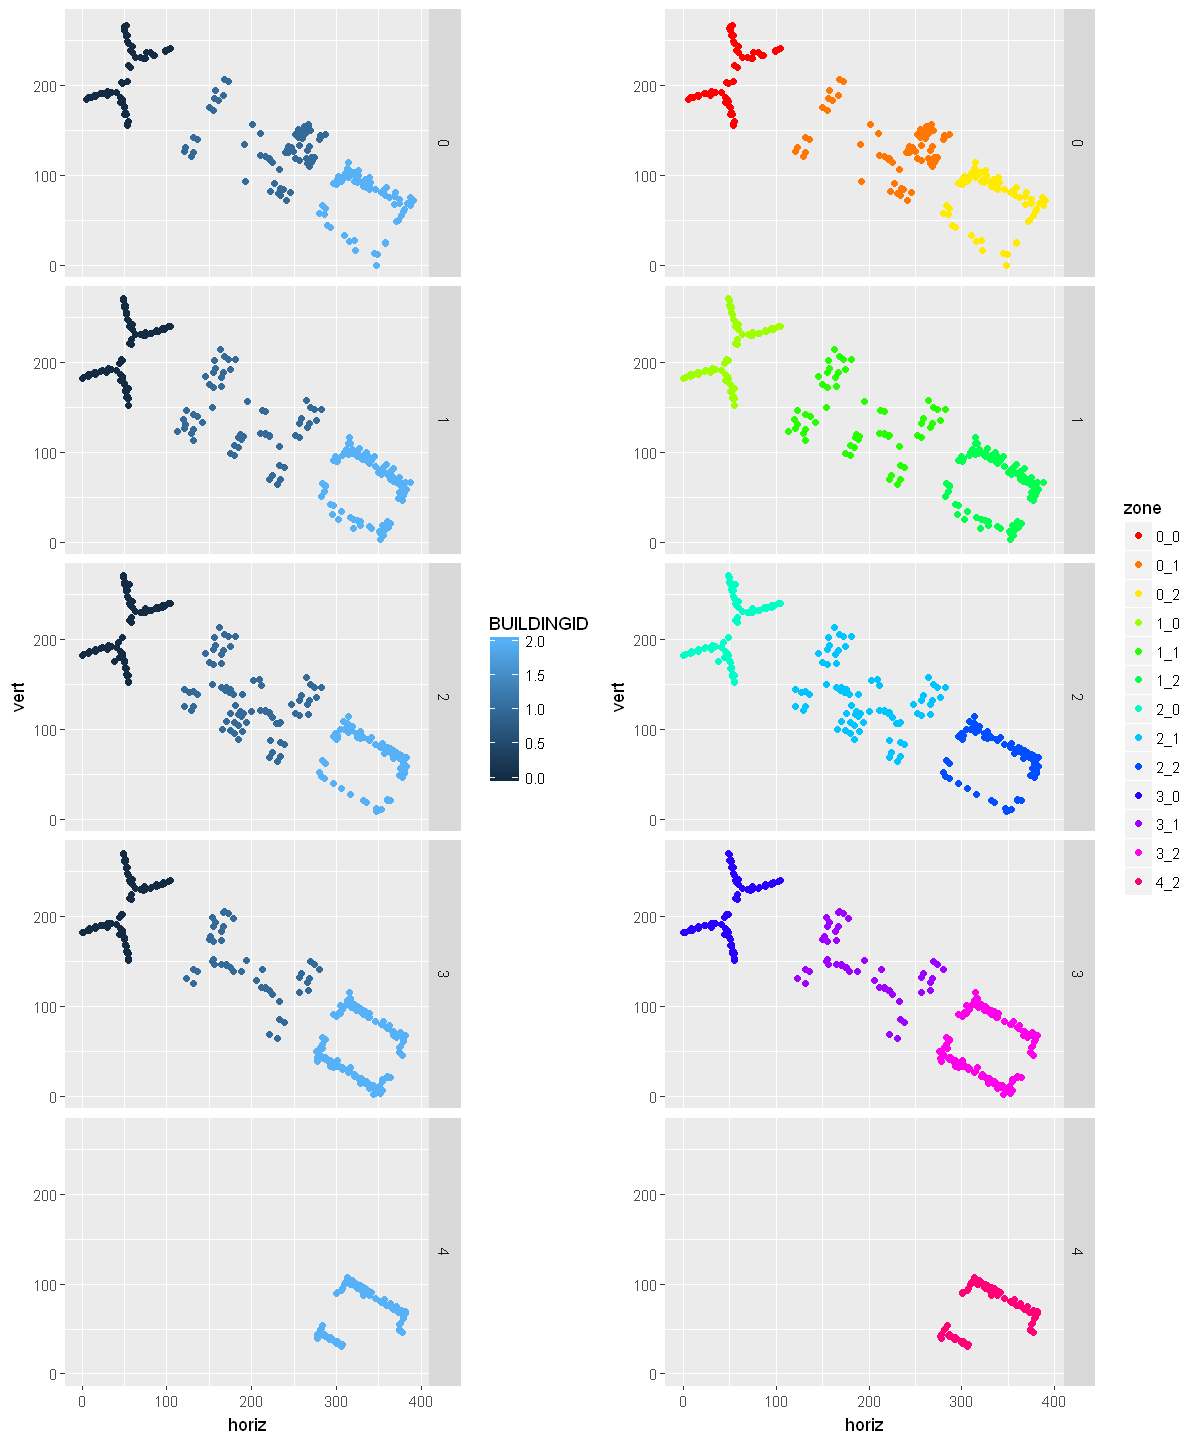

In [64]:
options(repr.plot.width=10, repr.plot.height=12)
p1 <- ggplot(dati,aes(x=horiz,y=vert,col=BUILDINGID))+geom_point()+facet_grid( FLOOR ~ .)
p2 <- ggplot(dati,aes(x=horiz,y=vert,col=zone))+geom_point()+facet_grid( FLOOR ~ .)+scale_colour_manual(values=rainbow(13))
multiplot(p1,p2, cols = 2)

**Coordinates dependence of WAP041 intensity (dBm)**

We consider WAP041 as an example to visualize how the signal intensity (dBm) depends on the person location inside the building. 

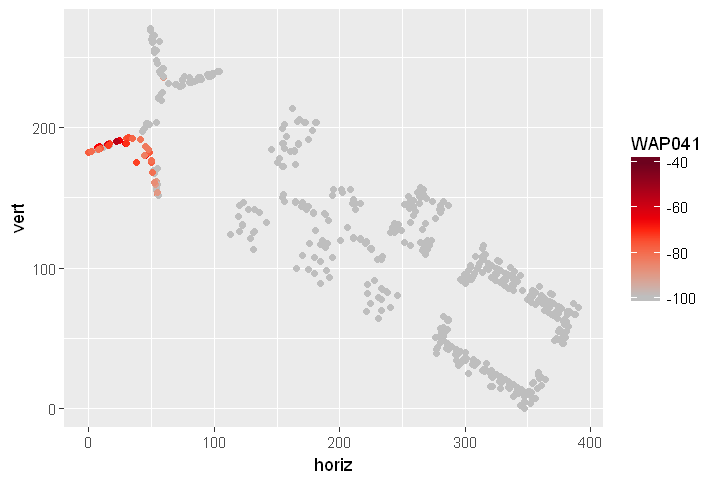

In [65]:
options(repr.plot.width=6, repr.plot.height=4)
dati_w <- dati[,c("WAP041","horiz","vert")]
dati_w <- dati_w %>% mutate("WAP041"= ifelse(WAP041 == 100, -100, WAP041))
ggplot(dati_w,aes(x=horiz,y=vert,col=WAP041))+geom_point()+scale_colour_gradientn(colours=c("gray","red","#5F021F"))

**We check how the signal of WAP041 is distributed on the four floors **

Looking at the distribution of the signal related to WAP041 we can tell that it is located in the building 2 on the second floor.

In [66]:
dati_melt <- melt(dati[,c("WAP041","horiz","vert","FLOOR")],id=c("vert","horiz","FLOOR"))

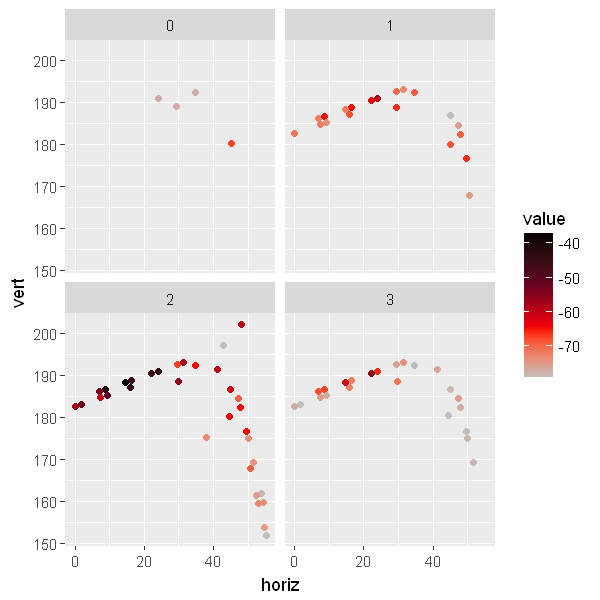

In [67]:
options(repr.plot.width=5, repr.plot.height=5)
aa <- dati_melt[dati_melt$variable == "WAP041",]
ggplot(aa[(aa$value > -80),],aes(x=horiz,y=vert,col=value))+geom_jitter()+facet_wrap( ~ FLOOR)+
scale_colour_gradientn(colours=c(adjustcolor( "gray", alpha.f = 1),"red","#5F021F","black"))

**Distribution of intensity values **

We observe that 96% of the waps entries contains zero-intensity values (-100 dBm). Only 4% of the entries contains  non-zero-intensity values. 

In [68]:
dw <- melt(dati[,c(1:465)])

No id variables; using all as measure variables


In [69]:
print(paste0("Number of zero intensity values ",round(dim(dw[dw$value == -100,])[1]/9270705*100)," %"))
print(paste0("Number of nonzero intensity values ",round(dim(dw[dw$value != -100,])[1]/9270705*100)," %"))

[1] "Number of zero intensity values 96 %"
[1] "Number of nonzero intensity values 4 %"


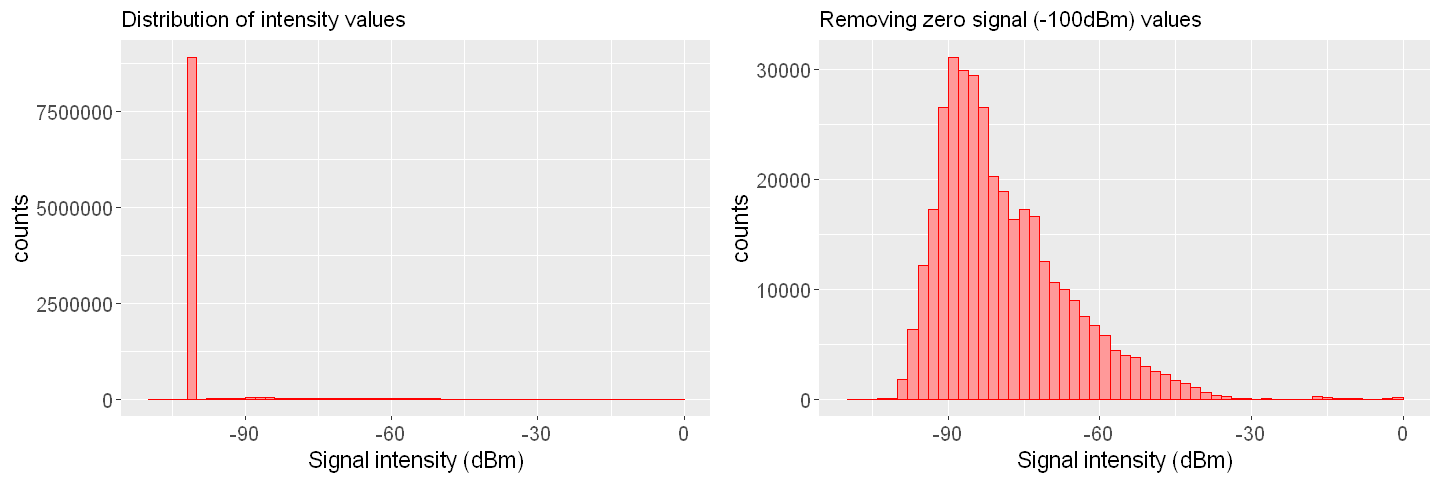

In [70]:
options(repr.plot.width=12, repr.plot.height=4)

pp1 <- ggplot(dw,aes(x=value))+geom_histogram(col="red",fill="#ff9999",breaks=seq(-110, 0, by =2))+
theme(axis.text=element_text(size=12),axis.title=element_text(size=14))+ ylab("counts")+xlab("Signal intensity (dBm)")+
ggtitle("Distribution of intensity values")

pp2 <- ggplot(dw[which(dw$value !=-100),],aes(x=value))+geom_histogram(col="red",fill="#ff9999",breaks=seq(-110, 0, by =2))+
theme(axis.text=element_text(size=12),axis.title=element_text(size=14))+ ylab("counts")+xlab("Signal intensity (dBm)")+
ggtitle("Removing zero signal (-100dBm) values")

multiplot(pp1,pp2, cols = 2)

## <a id="p4_3">Removing outliers</a>

We observe that some WAPs record high intensity values that are out of the typical WAPs intensity distribution. If we look at the spatial intensity distribution, we see that these high values seem to be located far from the bulk of the nonzero intensity points (where we suppose the WAP is located). We also observe that such values were collected almost entirely by just one user (USER6). We think that they are probably related to wrong measurements, and we decide to substitute them with -100dBm in the dataset (zero-intensity values).

In [71]:
dati_melt1 <- melt(dati[,c("WAP012","horiz","vert","FLOOR")],id=c("vert","horiz","FLOOR"))

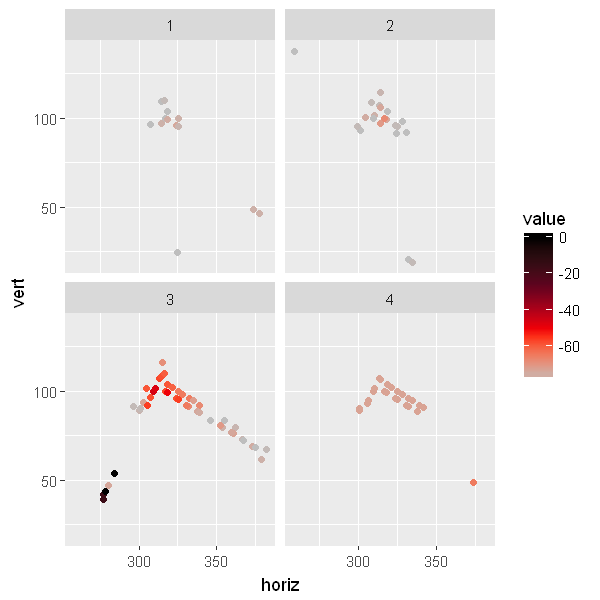

In [72]:
options(repr.plot.width=5, repr.plot.height=5)
aa <- dati_melt1[dati_melt1$variable == "WAP012",]
ggplot(aa[(aa$value > -80),],aes(x=horiz,y=vert,col=value))+geom_jitter()+facet_wrap( ~ FLOOR)+
scale_colour_gradientn(colours=c(adjustcolor( "gray", alpha.f = 1),"red","#5F021F","black"))

In [73]:
dw <- melt(dati[,c(1:465)])
dw1 <- melt(dati[dati$USERID == 6,c(1:465)])

No id variables; using all as measure variables
No id variables; using all as measure variables


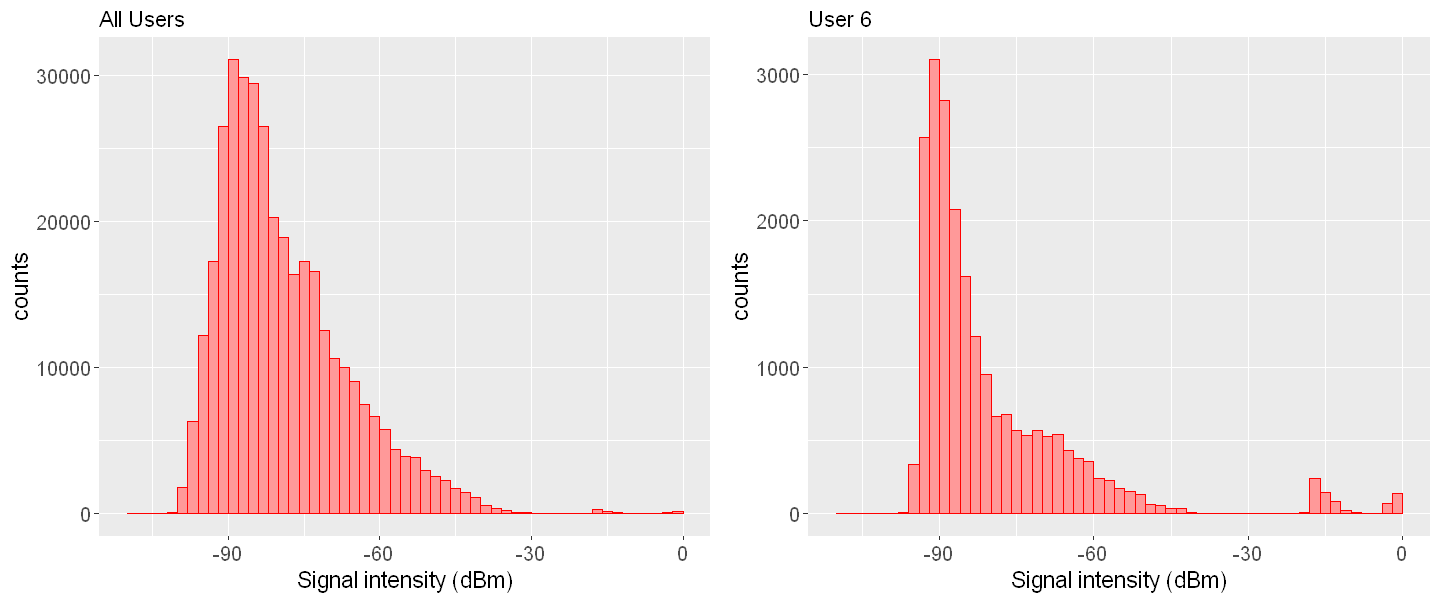

In [74]:
options(repr.plot.width=12, repr.plot.height=5)

pp1 <- ggplot(dw[which(dw$value !=-100),],aes(x=value))+geom_histogram(col="red",fill="#ff9999",breaks=seq(-110, 0, by =2))+
theme(axis.text=element_text(size=12),axis.title=element_text(size=14))+ ylab("counts")+xlab("Signal intensity (dBm)")+
ggtitle("All Users")

pp2 <- ggplot(dw1[which(dw1$value !=-100),],aes(x=value))+geom_histogram(col="red",fill="#ff9999",breaks=seq(-110, 0, by =2))+
theme(axis.text=element_text(size=12),axis.title=element_text(size=14))+ ylab("counts")+xlab("Signal intensity (dBm)")+
ggtitle("User 6")

multiplot(pp1,pp2, cols = 2)

In [75]:
dati_out1 <- melt(dati[,c(1:465,472)],id="USERID")

In [76]:
print(paste("Total # of high values (> -20): ", dim(dati_out1[dati_out1$value > -20,])[1]))
print(paste0("# of high values (> -20) for USER6: ", dim(dati_out1[dati_out1$value > -20 & dati_out1$USERID == 6,])[1]))
print(paste0("# of high values (> -20) for USER14: ", dim(dati_out1[dati_out1$value > -20 & dati_out1$USERID == 14,])[1]))

[1] "Total # of high values (> -20):  738"
[1] "# of high values (> -20) for USER6: 700"
[1] "# of high values (> -20) for USER14: 38"


**Put all values higher than -20dBm to zero intensity (-100dBm) **

In [77]:
dati[,c(1:465)] <- dati[,c(1:465)] %>% apply(2,function(x) ifelse(x > -20 , -100, x))

## <a id="p4_4">4 Preprocessing strategies</a>

We try different preprocess strategies and for each preprocessing we train different models for zone prediction.

<img src="01_preprocess.png" style="width: 400px;" align="left"/>

**Preprocess 3: normalized signals **

In [78]:
dati3 <- dati

In [79]:
transp <- (t(dati3[,c(1:465)] ))
transp <- transp %>% apply(2, function(x) (x-min(x))/(max(x)-min(x)))
dati3[,c(1:465)] <- t(transp)

Remove rows with NaN

In [80]:
dati3 <- (dati3[complete.cases(dati3), ])

## <a id="p5">Location prediction: zone (classification)</a>


**Create train- test (80% - 20%), stratified wit variable "zone"**

In [81]:
trainIndex <- createDataPartition(dati3$zone, p = .8,list=FALSE,times = 1)
train <- dati3[trainIndex,]
test <- dati3[-trainIndex,]

We create a subsample of the train set (10%) to perform model selection through cross-validation: 1595 instances

In [82]:
sampleIndex <- createDataPartition(train$zone, p= .1,list=FALSE,times = 1)
sample <- train[sampleIndex,]

In [83]:
dim(sample)

[1] 1595  477

<big> **Model selection: Training of different models with cross-validation on subsample (1595 instances)  ** </big>

We use 10-fold cross-validation, repeated 20 times for testing different model parameters.

**k-nn **

In [84]:
#t <- proc.time()
#set.seed(400)
#ctrl <- trainControl(method="repeatedcv",number=10,repeats = 1)
#knnFit <- train(zone ~ ., data = sample[,c(1:465,477)], method = "knn", trControl = ctrl, tuneLength = 20)
#proc.time()-t

In [85]:
#saveRDS(knnFit, "report_knn_01.rds") 

In [86]:
knnFit <- readRDS("report_knn_01.rds")

In [87]:
knnFit

k-Nearest Neighbors 

1595 samples
 465 predictor
  13 classes: '0_0', '0_1', '0_2', '1_0', '1_1', '1_2', '2_0', '2_1', '2_2', '3_0', '3_1', '3_2', '4_2' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 1437, 1435, 1434, 1437, 1435, 1434, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.9768427  0.9747191
   7  0.9699084  0.9671473
   9  0.9636346  0.9602932
  11  0.9498330  0.9452047
  13  0.9417038  0.9363230
  15  0.9329257  0.9266971
  17  0.9184951  0.9109220
  19  0.9084515  0.8999630
  21  0.8959236  0.8862407
  23  0.8896457  0.8793793
  25  0.8877587  0.8772923
  27  0.8789965  0.8676650
  29  0.8739925  0.8621595
  31  0.8689728  0.8566284
  33  0.8664925  0.8539047
  35  0.8658871  0.8532513
  37  0.8652424  0.8525515
  39  0.8539998  0.8402198
  41  0.8501985  0.8360449
  43  0.8489445  0.8346577

Accuracy was used to select the optimal model using  the largest value.
The final value u

**C5.0 ** 

In [88]:
#t <- proc.time()
#set.seed(400)
#ctrl <- trainControl(method="repeatedcv",number=10,repeats = 1)
#C50Fit <- train(zone ~ ., data = sample[,c(1:465,477)], method = "C5.0", trControl = ctrl, tuneLength = 20)
#proc.time()-t

In [89]:
#saveRDS(C50Fit, "report_C50_01.rds") 

In [90]:
C50Fit <- readRDS("report_C50_01.rds")

In [91]:
C50Fit

C5.0 

1595 samples
 465 predictor
  13 classes: '0_0', '0_1', '0_2', '1_0', '1_1', '1_2', '2_0', '2_1', '2_2', '3_0', '3_1', '3_2', '4_2' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 1437, 1435, 1434, 1437, 1435, 1434, ... 
Resampling results across tuning parameters:

  model  winnow  trials  Accuracy   Kappa    
  rules  FALSE     1     0.8771613  0.8657947
  rules  FALSE    10     0.9599084  0.9562348
  rules  FALSE    20     0.9730888  0.9706277
  rules  FALSE    30     0.9699715  0.9672233
  rules  FALSE    40     0.9712295  0.9685910
  rules  FALSE    50     0.9712333  0.9685987
  rules  FALSE    60     0.9706122  0.9679206
  rules  FALSE    70     0.9681082  0.9651886
  rules  FALSE    80     0.9705965  0.9679061
  rules  FALSE    90     0.9706122  0.9679241
  rules  FALSE   100     0.9737217  0.9713169
  rules   TRUE     1     0.8695552  0.8574750
  rules   TRUE    10     0.9210387  0.9138074
  rules   TRUE    20     0.9

**Random Forest ** 

In [92]:
#t <- proc.time()
#set.seed(400)
#ctrl <- trainControl(method="repeatedcv",number=10,repeats = 1)
#rfFit <- train(zone ~ ., data = sample[,c(1:465,477)], method = "rf", trControl = ctrl, tuneLength = 20)
#proc.time()-t

**Summary of all the trained models performance**

<img src="02_modelszone1.png" style="width: 400px;" align="left"/>

<big> **Validation of the selected model: training on the full train set, validation on test set ** </big>

We choose the best performing model (Random Forest, parameters: mtry = 52 ), preprocess 3. We train the model on the full train set and test it on the test set.

In [94]:
# MODEL RANDOM FOREST (mtry = 52), (parameter chosen from previous tests with subsets)

#t <- proc.time()
#set.seed(400)
#rfFit <- train(zone ~ ., data = train[,c(1:465,477)], method = "rf", trControl = trainControl(method="none"), preProcess = c("center","scale","zv"), tuneLength = 1, tuneGrid = data.frame(.mtry = 52))
#proc.time()-t

In [95]:
rfFit <- readRDS("rf_dbnorm_training.rds")

In [99]:
predictions <- predict(rfFit, test[,c(1:465)])
results <- test[,c(1:465,477)]
results$pred_zone <- predictions
res <- results[,c("zone","pred_zone")]
res <- res %>% mutate("correct"= ifelse(pred_zone == zone,1,0) )

accuracy <- sum(res$correct)/length(res$correct)
accuracy ## Accuracy 0.9977

[1] 0.9992438

**Misclassified instances **

In [98]:
res[res$correct == 0,]

,zone,pred_zone,correct
488,3_2,2_2,0
3034,1_1,0_1,0
3200,0_0,1_0,0


> **We use the best performing model (Random Forest, mtry = 52) combined to data preprocessing3 (normalized data) to predict "zone". **

> **We can predict "zone" with a very high accuracy: 99.9%. The "building" is predicted with 100% accuracy, while there are only 3 misclassifications for "floor" prediction. In these cases the position is wrongly assigned to an upper or lower floor.**

## <a id="p6">Location prediction: coordinates (regression)</a>

We use the same workflow used for "zone" prediction, to predict location coordinates. In this case we use regression models:

**1 - Model selection (10- fold cross-validation, x20 for best model parameters selection) on a 10% subset of the trainig set (1595 instances)**

<img src="02_modelszone2.png" style="width: 400px;" align="left"/>

** 2 - Validation of the selected models: training on the full train set, validation on test set **

<img src="02_modelszone2bis.png" style="width: 400px;" align="left"/>

We observe that k-nn performs better in terms of MAE (mean absolute error), while random forest performs better in terms of RMSE (root mean squared error). From the distribution of errors we see that k-nn tends to produce lowers errors in general, but few very high errors, that amplify the RMSE metric. Random forest produces slightly higher errors in general, but fewer "extreme" errors.

<img src="02_errors.png" style="width: 800px;" align="left"/>

## <a id="p7">Conclusion</a>

> ** We are able to predict indoor location of a user based on wifi fingerprint with a quite good accuracy. We predict building with 100% accuracy and floor with 99.9% accuracy. We can predict the location coordinates with a range of error of about 9m for the horizontal coordinate and 6m for the vertical coordinate.**

<img src="02_conclusion.png" style="width: 600px;" align="left"/>